# Домашнее задание по теме “Синтаксический анализ”

## Задание 1: Составление словарей для классификации по тональности

При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.

Составление таких словарей вручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).

Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
 - тест на определение ближайших слов
 - тест на аналогии (мужчина – король : женщина – королева)
 - тест на определение лишнего слова.
4. Постройте несколько визуализаций:
 - TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
 - задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [92]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pymorphy2

import pandas as pd
import numpy as np
import nltk
import re
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:50, 1815.16it/s]


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [9]:
from nltk.corpus import stopwords

In [10]:
stops = stopwords.words('russian')

In [8]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')

In [30]:
morph = pymorphy2.MorphAnalyzer()

In [31]:
def review_to_wordlist(review, remove_stopwords=False ):

    # оставляем только буквенные символы
    review_text = re.sub("[^А-Яа-я]"," ", review)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = review_text.lower().split()
    words_lemmatized = [morph.parse(w)[0].normal_form for w in words]
    if remove_stopwords: # убираем стоп-слова
        words_lemmatized = [w for w in words_lemmatized if not w in stops]
    return(words_lemmatized)

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # разбиваем обзор на предложения
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # применяем предыдущую функцию к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [33]:
review_to_sentences('Мы не знали друг друга до этого лета. Мы болтались по свету, земле и воде', tokenizer, True)

[['знать', 'друг', 'друг', 'это', 'лето'],
 ['болтаться', 'свет', 'земля', 'вода']]

In [83]:
review_to_wordlist('Мы не знали друг друга до этого лета. Мы болтались по свету, земле и воде', True)

['знать', 'друг', 'друг', 'это', 'лето', 'болтаться', 'свет', 'земля', 'вода']

In [34]:
sentences = []  

for review in tqdm(df["text"]):
    sentences += review_to_sentences(review, tokenizer)

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [4:36:02<00:00,  9.27it/s]


In [35]:
with open('sentences.txt', 'w', encoding='utf-8') as f:
    for sent in sentences:
        f.write("%s\n" % sent)

In [36]:
sentences[:2]

[['добрый', 'день'],
 ['я',
  'не',
  'являться',
  'клиент',
  'банк',
  'и',
  'поручитель',
  'по',
  'кредитный',
  'договор',
  'а',
  'также',
  'не',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'с',
  'банк',
  'по',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

In [37]:
from gensim.models import word2vec

In [38]:
model = word2vec.Word2Vec(sentences, workers=4, vector_size=300, min_count=10, window=10, sample=1e-3)

In [40]:
print(f'В текущей модели word2vec {len(model.wv.key_to_index)} слов')

В текущей модели word2vec 24495 слов


In [46]:
# тест на определение ближайших слов
words = ['банк', 'кредит', 'чек', 'операция', 'задолженность', 'звонок', 'очередь']

for w in words:
    if w not in model.wv:
        print(f'"{w}" не найдено')
    else:
        print(f'"{w}" топ-5 похожих слов:')
        pprint(model.wv.most_similar(w)[:5])

"банк" топ-5 похожих слов:
[('росбанк', 0.5007713437080383),
 ('брс', 0.4715321958065033),
 ('райффайзенбанк', 0.4571521580219269),
 ('ситибанк', 0.4564133584499359),
 ('бинбанка', 0.4522295594215393)]
"кредит" топ-5 похожих слов:
[('автокредит', 0.8104761242866516),
 ('ипотека', 0.693213939666748),
 ('потребкредить', 0.6476704478263855),
 ('ссуда', 0.6393988132476807),
 ('рассрочка', 0.6006852388381958)]
"чек" топ-5 похожих слов:
[('квитанция', 0.6909379363059998),
 ('слип', 0.5887035131454468),
 ('чековый', 0.5868744850158691),
 ('квиток', 0.581951379776001),
 ('экран', 0.5597659349441528)]
"операция" топ-5 похожих слов:
[('транзакция', 0.8400092720985413),
 ('трансакция', 0.7475876212120056),
 ('проводок', 0.5977960228919983),
 ('авторизация', 0.5610183477401733),
 ('манипуляция', 0.5482479929924011)]
"задолженность" топ-5 похожих слов:
[('задолжность', 0.8444154262542725),
 ('долг', 0.8044043183326721),
 ('заложенность', 0.575371503829956),
 ('недоплата', 0.5431759357452393),
 ('пр

Похожие слова определены достаточно адекватно, это действительно синонимы заданных слов либо те же слова, написанные с опечатками

In [54]:
# тест на аналогии
print(model.wv.most_similar(positive=['рубль', 'сша'], negative=['россия'])[0])

('евро', 0.6503366231918335)


Интересно, что получили евро, а не доллар, хотя такая аналогия в целом уместна 

In [74]:
print(model.wv.most_similar(positive=['вклад', 'карта'], negative=['кредит'])[0])

('депозит', 0.6405088305473328)


Операция с внесением денег на карту по смыслу обрадтная слову "кредит" - это депозит. Тоже логично

In [78]:
# тест на лишнее слово
model.wv.doesnt_match(['долг', 'просрочка', 'задолженность', 'страховка'])

'страховка'

In [79]:
model.wv.doesnt_match(['сбербанк', 'райффайзенбанк', 'ситибанк', 'банка'])

'банка'

Из созвучных слов ("банк" есть везде) выделена отличающаяся по смыслу "банка"

In [82]:
model.wv.doesnt_match(['быстро', 'оперативно', 'хорошо', 'удобно', 'очередь'])

'очередь'

### Визуализация кластеров слов (t-SNE)

Выделю несколько популярных слов, вокруг которых будут образовываться кластеры для более наглядной визуализации

In [114]:
keys = ['хорошо', 'банк', 'кредит', 'чек', 'клиент','счёт', 'депозит', 'звонок', 'очередь', 'сотрудник', 'плохо']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=25):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [90]:
from sklearn.manifold import TSNE

In [115]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


In [109]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)

    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

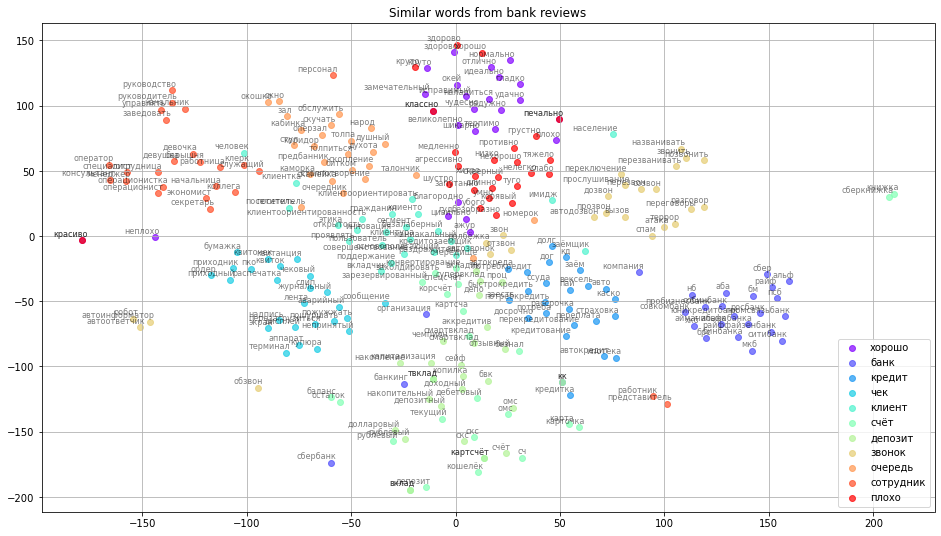

In [116]:
tsne_plot_similar_words('Similar words from bank reviews', keys, embeddings_2d, word_clusters, 0.7)

Хорошо просматриваются кластеры, построенные от слов "сотрудник", "банк", "очередь".  Кластер "звонок" разнесен на несколько мини-класетров на координатной плоскости, но отделен от прочих кластеров. Накладываются друг на друга кластеры "хорошо" и "плохо", и это достаточно интересно, можно даже увидеть, что один и те же слова ("здорово") попали и в тот, и в другой кластер. Так же частично перекрывают друг друга, например, кластеры "счет" и "депозит", но это понятия, близкие, так что такое поведение ожидаемо.   

### Банки в координатах хорошо-плохо, быстро-медленно

In [130]:
# базис
v1 = model.wv['хорошо'] - model.wv['плохо']
v2 = model.wv['быстро'] - model.wv['медленно']

banks = ['сбербанк', 'альфабанк', 'хоумкредит', 'райффайзенбанк', 'втб', 'тинькофф', 'россельхозбанк', 'авангард', 'ситибанк', 'промсвязьбанк','ренессанс']
x_coord, y_coord = [], []
for bank in banks:
    x_coord.append(np.dot(v1, model.wv[bank]))
    y_coord.append(np.dot(v2, model.wv[bank]))

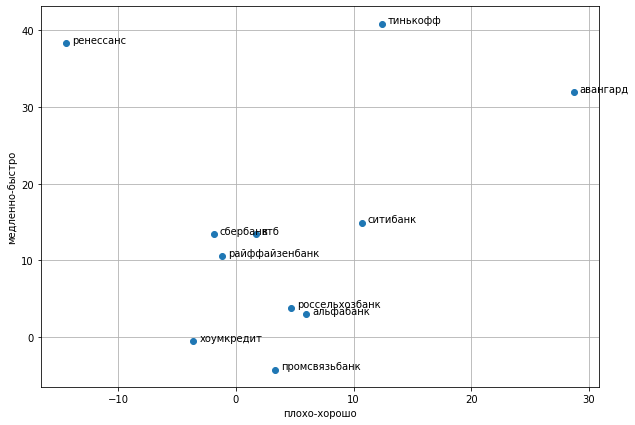

In [131]:
plt.figure(figsize=(10, 7))
plt.scatter(x_coord, y_coord)
for i, name in enumerate(banks):
    plt.annotate(name, (x_coord[i]+0.5, y_coord[i]))
plt.xlabel('плохо-хорошо')
plt.ylabel('медленно-быстро')
plt.grid()

## Задание 2: Распространение метки
Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8 негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в вершине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:

1. graphlab.label_propagation (graphlab доступен бесплатно по образовательной лицензии)
1. sklearn.semi_supervised.LabelPropagation
1. sklearn.semi_supervised.LabelSpreading

Пример построения графа: см. ноутбук, размещенный в текущей папке репозитория

In [175]:
from igraph import *

In [198]:
g = Graph(directed=True)
labels = []
fixes = []
weights = []

In [185]:
def analyse_graph(g):
    print("Number of vertices:", g.vcount())
    print("Number of edges:", g.ecount())

In [182]:
positive_words = ['приятный', 'хорошо', 'удобный', 'доходный', 'положительный', 'выбор', 'быстрый']
negative_words = ['просрочка', 'очередь', 'медленный', 'неграмотный', 'плохо', 'толпа', 'терять']

In [183]:
keys = list(model.wv.key_to_index)

In [199]:
# создаем вершины графа с разметкой
for word in keys:
    label = -1  # у всех слов
    fix = False
    if  word in positive_words:
        label = 1  # положительная метка
        fix = True
    if word in negative_words:
        label = 0  # отрицательная метка
        fix = True

    labels.append(label)
    fixes.append(fix)

    g.add_vertex(word)

In [200]:
analyse_graph(g)

Number of vertices: 24495
Number of edges: 0


In [201]:
# создаем ребра графа с весами
for word in keys:
    node = g.vs.select(name=word).indices[0]
    similar_words = model.wv.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name=word1).indices[0]
        g.add_edge(node, new_node, weight = val)
        weights.append(val)


In [202]:
analyse_graph(g)

Number of vertices: 24495
Number of edges: 122475


In [203]:
m = g.community_label_propagation(initial=labels, weights=weights, fixed=fixes)


In [204]:
from collections import  Counter

Визуализировать граф с 24000 вершинами кажется делом неблагодарным, поэтому, чтобы проверить, что метки присвоены, посчитаем их количество. 

In [205]:
Counter(m.membership)


Counter({-1: 9449, 0: 12541, 1: 2505})

Как видим, метки присвоены нескольким тысячам объектов, тогда как в начале было всего по 7 меток положительных и отрицательных. 

Прокомментирую, почему -1 - метка для неразмеченных данных, а не для отрицательного класса. Когда при создании вершин графа с метками все вершины помечались 0 и только слова из списка цифрами 1/-1, тогда после выполнения алгоритма label propagation оставалось 8 меток "+1", остальные "0", "-1" загадочным образом не присутствовали совсем. После разметки исходных данных на "-1" - все, "0" - отрицательные, "+1" - положительные получаю картину более похожую на адекватное присвоение меток.